In [1]:
%pip install accelerate==0.27.2
%pip install sentence-transformers
%pip install awswrangler
%pip install --upgrade sentence_transformers

  Using cached accelerate-0.27.2-py3-none-any.whl.metadata (18 kB)
Using cached accelerate-0.27.2-py3-none-any.whl (279 kB)
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.21.0
    Uninstalling accelerate-0.21.0:
      Successfully uninstalled accelerate-0.21.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.2 requires accelerate<0.22.0,>=0.21.0, but you have accelerate 0.27.2 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
  Using cached sentence_transformers-3.0.1-py3-none-any.whl.metadata (10 kB)
  Using cached transformers-4.41.2-py3-none-any.whl.metadata (43 kB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.7 kB)
Using cached sentence_transformers-3.0.1-py3-none-any.whl (227 kB)
Using cached transforme

### Download model

In [28]:
import boto3
import os

def download_s3_folder(bucket_name, s3_folder, local_path):
    """
    Download a folder (or "prefix") from S3 to the local filesystem.
    """
    s3 = boto3.client('s3')
    paginator = s3.get_paginator('list_objects_v2')
    for result in paginator.paginate(Bucket=bucket_name, Prefix=s3_folder):
        if 'Contents' in result:
            for key in result['Contents']:
                # Extract file name from S3 key
                key_name = key['Key']
                local_file_path = os.path.join(local_path, os.path.basename(key_name))
                
                # Check if the key represents a folder
                if key_name.endswith('/'):
                    # Create local directory if it doesn't exist
                    os.makedirs(local_file_path, exist_ok=True)
                    # Recursively download folder contents
                    download_s3_folder(bucket_name, key_name, local_file_path)
                else:
                    # Create directory if it doesn't exist
                    os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
                    # Download file
                    try:
                        s3.download_file(bucket_name, key_name, local_file_path)
                    except NotADirectoryError as e:
                        print(f"Skipping file '{key_name}' due to error: {e}")

# Example usage
bucket_name = 'cleo-data-science'
base_name_path = 'model9/checkpoint-1600'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}"
local_path = f"/home/sagemaker-user/models/{base_name_path}"

download_s3_folder(bucket_name, s3_folder, local_path)

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)


In [24]:

bucket_name = 'cleo-data-science'
s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/{base_name_path}/1_Pooling"
local_path = f"/home/sagemaker-user/models/{base_name_path}/1_Pooling"


download_s3_folder(bucket_name, s3_folder, local_path)

In [4]:
!ls /home/sagemaker-user/models/

model3-600  model7  model8  model9


In [5]:
imodel = 9

In [5]:
# for istep in range(200, 4000, 200):
#     print(istep)
#     # Example usage
#     bucket_name = 'cleo-data-science'
#     s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/model{imodel}/checkpoint-{istep}"
#     local_path = f"/home/sagemaker-user/models/model{imodel}-{istep}"

#     download_s3_folder(bucket_name, s3_folder, local_path)

#     bucket_name = 'cleo-data-science'
#     s3_folder = f"transaction_enrichment/experimental_data/caste/pairs_model/model{imodel}/checkpoint-{istep}/1_Pooling"
#     local_path = f"/home/sagemaker-user/models/model{imodel}-{istep}/1_Pooling"

#     download_s3_folder(bucket_name, s3_folder, local_path)

In [6]:
!ls /home/sagemaker-user/models/

model3-600  model7  model8  model9


### Load Labelbox data

### Load test data

In [7]:
%pip install awswrangler

Note: you may need to restart the kernel to use updated packages.


In [8]:
import awswrangler as wr
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/processed/trans_2024-05-14_2024-05-14"
# s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"

# df_data_processed = wr.s3.read_parquet(path=s3_path)
# df_data_processed.shape

In [10]:
# df_data_processed[df_data_processed['true_merchant_name_combined'] == 'Cleo Re']

In [11]:
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/trans_2024-05-14_2024-05-14_top_2001.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/ac45bd41a9274be39fe18728158c8beb.snappy.parquet"
s3_path = "s3://cleo-data-science/transaction_enrichment/experimental_data/caste/trx-merchant-pair/cons_2024-05-15_2024-05-18_1.parquet/"


df_data_raw = wr.s3.read_parquet(path=s3_path)
df_data_raw.shape

(11199380, 11)

In [12]:
import re
pattern = r"Cash\sApp\s(?!Transfer)[\w\s]+"
result = re.sub(pattern, "Cash App", 'Cash App Transfer')
result
df_data_raw['original_merchant_name_combined'] = df_data_raw['original_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )
df_data_raw['true_merchant_name_combined'] = df_data_raw['true_merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x))
df_data_raw['merchant_name_combined'] = df_data_raw['merchant_name_combined'].apply(lambda x: re.sub(pattern, "Cash App", x) )

In [13]:
df_ , df_test, y_, y_test = train_test_split(df_data_raw, df_data_raw['true_label'], test_size = 0.05, random_state=1)
df_train, df_val, y_train, y_val = train_test_split(df_, df_['true_label'], test_size = 0.05, random_state=1)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
print(df_train.shape[0], df_test.shape[0], df_val.shape[0])

10107440 559969 531971


In [14]:
df_train.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9809572531,DOLLAR TR S REED KOKOMO IN. Channel: in store....,DOLLAR TR S REED KOKOMO IN. Type: merchant. Ch...,DOLLAR TR S REED KOKOMO IN,Dollar Tree,0,Dollar Tree,-44.9,Dollar Tree,1,0.631608
1,9818695806,WINGSTOP CASTLE ROCK CO. Channel: in store. Am...,WINGSTOP CASTLE ROCK CO. Type: merchant. Chann...,WINGSTOP CASTLE ROCK CO,Wingstop,0,Wingstop,-18.3,Wingstop,1,0.748854
2,9819041348,RACETRAC 05-16-24 LANTANA FL DEBIT CARD PURCHA...,RACETRAC 05-16-24 LANTANA FL DEBIT CARD PURCHA...,RACETRAC 05-16-24 LANTANA FL DEBIT CARD PURCHA...,Racetrac,0,Racetrac,-9.4,Racetrac,1,0.913400
3,9836293432,"H-E-B, LP PAYROLL CALDERON, LUIS. Channel: Non...","H-E-B, LP PAYROLL CALDERON, LUIS. Type: . Chan...","H-E-B, LP PAYROLL CALDERON, LUIS",Heb,0,Heb,583.9,Heb,1,0.605342
4,10008115332,Duane Reade Sto 401 E 8. Channel: in store. Am...,Duane Reade Sto 401 E 8. Type: merchant. Chann...,Duane Reade Sto 401 E 8,Duane Reade,0,Duane Reade,-40.1,Sam''s Club,0,0.096898


In [15]:
df_test[df_test['original_merchant_name_combined'] == 'Cash App']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
196,9814716512,CASH APP*EDWAR 05/15 # PMNT RCVD CASH APP*EDWA...,CASH APP*EDWAR 05/15 # PMNT RCVD CASH APP*EDWA...,CASH APP*EDWAR 05/15 # PMNT RCVD CASH APP*EDWA...,Cash App,0,Cash App,98.2,Cash App,1,0.894218
280,9822517025,Pos Debit- Cash App*raven 800- CA. Channel: No...,Pos Debit- Cash App*raven 800- CA. Type: payme...,Pos Debit- Cash App*raven 800- CA,Cash App,0,Cash App,-5.0,Possible Finance,0,0.284487
304,9797543267,CASH APP*DESIREE*CASH. Channel: None. Amount: ...,CASH APP*DESIREE*CASH. Type: payment_app. Chan...,CASH APP*DESIREE*CASH,Cash App,0,Cash App,10.8,Cash App,1,0.651252
496,9811185410,"DEBIT CARD PURCHASE AT CASH APP*CHRISTOPH, SAN...","DEBIT CARD PURCHASE AT CASH APP*CHRISTOPH, SAN...","DEBIT CARD PURCHASE AT CASH APP*CHRISTOPH, SAN...",Cash App,0,Cash App,-230.0,Smith''s Food,0,0.019805
569,9817378780,Withdrawal Debit CASH APP*DANIEL TAYLOR*AD 800...,Withdrawal Debit CASH APP*DANIEL TAYLOR*AD 800...,Withdrawal Debit CASH APP*DANIEL TAYLOR*AD 800...,Cash App,1,Cash App,-20.0,Brothers Fuel,0,0.027568
...,...,...,...,...,...,...,...,...,...,...,...
559586,9829835788,POS Return CASH APP*LOL*CASH / OSan Francisco ...,POS Return CASH APP*LOL*CASH / OSan Francisco ...,POS Return CASH APP*LOL*CASH / OSan Francisco ...,Cash App,0,Cash App,4.8,Cash App,1,0.876368
559602,9816945369,CASH APP*JORDAN*CASH OU San Francisco CA. Chan...,CASH APP*JORDAN*CASH OU San Francisco CA. Type...,CASH APP*JORDAN*CASH OU San Francisco CA,Cash App,1,Cash App,14.7,Draftkings,0,0.022450
559708,9825168233,Pos Debit- Cash App*moe98 San Francisco CA. Ch...,Pos Debit- Cash App*moe98 San Francisco CA. Ty...,Pos Debit- Cash App*moe98 San Francisco CA,Cash App,0,Cash App,-40.0,ExxonMobil,0,0.041613
559774,9818700381,CASH APP*KARIN 05/15 # PMNT RCVD CASH APP*KARI...,CASH APP*KARIN 05/15 # PMNT RCVD CASH APP*KARI...,CASH APP*KARIN 05/15 # PMNT RCVD CASH APP*KARI...,Cash App,0,Cash App,59.0,MoneyLion,0,0.150250


In [16]:
df_merchants_counts = df_train['original_merchant_name_combined'].value_counts().to_frame()
df_merchants_counts.reset_index(drop=False, inplace=True)
top_merchants  = df_merchants_counts[0:2000]['original_merchant_name_combined'].to_list()
top_merchants

['Savings',
 'Cash App',
 'Dave Inc',
 'Walmart',
 'Cash Withdrawal',
 'Earnin',
 "McDonald''s",
 '7 Eleven',
 'Venmo',
 'Circle K',
 'Apple',
 'Amazon',
 'Albert',
 'Shell',
 'Cleo',
 'Dollar General',
 'MoneyLion',
 'Brigit',
 'Empower',
 'Online Banking Transfer',
 'Klover',
 'Uber',
 'Affirm',
 'Amazon Prime',
 'Klarna',
 'Afterpay',
 'Target',
 "Dunkin'' Donuts",
 'Paypal',
 'FloatMe',
 'Starbucks',
 'Zip In',
 'QuikTrip',
 'Doordash',
 'Taco Bell',
 'Chick-fil-A',
 'BP',
 'Walgreens',
 'Speedway',
 'Chevron',
 'Fan Duel Sportsbook',
 'Sezzle',
 'Uber Eats',
 "Wendy''s",
 'Lyft',
 'Dollar Tree',
 'CVS Pharmacy',
 'Kroger',
 'Draftkings',
 '365 Markets',
 'Wawa',
 'Bank of America ATM',
 'Family Dollar',
 'Burger King',
 'Cash App Transfer',
 'ExxonMobil',
 'Publix',
 'Overdraft Charge',
 'Sunoco',
 'Grid',
 'T-Mobile',
 'Sonic',
 'Bank of America - Keep the Change',
 "Casey''s Lincoln",
 'Daily Pay',
 'Netflix',
 'Sheetz',
 'Murphy Express',
 'Chipotle',
 'Food Lion',
 'Racetrac',

In [61]:
df_test_all = df_test.copy(deep=True)
df_test = df_test[df_test['true_merchant_name_combined'].isin(top_merchants)][:]
df_test.reset_index(drop=True, inplace=True)
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9994008807,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,O''Reilly Auto Parts,0,O''Reilly Auto Parts,-48.4,Nando''s PERi-PERi,0,0.169511
1,9816935543,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee,0,ATM Fee,-1.0,ATM Fee,1,0.885608
2,9817615044,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave Inc,0,Dave Inc,-1.0,Red Rover,0,0.184990
3,9834581115,SHELL OIL ORLANDO FL 05/15. Channel: in store....,SHELL OIL ORLANDO FL 05/15. Type: merchant. Ch...,SHELL OIL ORLANDO FL 05/15,Shell,0,Shell,-5.4,Chillbox,0,0.101866
4,9807730741,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,Sunoco,0,Sunoco,-24.0,Sunoco,1,0.737140
...,...,...,...,...,...,...,...,...,...,...,...
488932,9813823567,TACO BELL # MIAMI FL. Channel: in store. Amoun...,TACO BELL # MIAMI FL. Type: merchant. Channel:...,TACO BELL # MIAMI FL,Taco Bell,0,Taco Bell,-12.6,Taco Bell,1,0.987514
488933,9829554602,PURCHASE WITH CASH BACK $ 160.00 AUTHORIZED ON...,PURCHASE WITH CASH BACK $ 160.00 AUTHORIZED ON...,PURCHASE WITH CASH BACK $ 160.00 AUTHORIZED ON...,US Postal Service,0,US Postal Service,-212.1,Army & Air Force Exchange Service,0,0.117474
488934,9821586322,PURCHASE AUTHORIZED ON 05/15 UBER TRIP HELP.UB...,PURCHASE AUTHORIZED ON 05/15 UBER TRIP HELP.UB...,PURCHASE AUTHORIZED ON 05/15 UBER TRIP HELP.UB...,Uber,0,Uber,-15.9,Shopify.Com,0,0.039378
488935,9808883895,YSI PULSZ.COM LONDON. Channel: online. Amount:...,YSI PULSZ.COM LONDON. Type: merchant. Channel:...,YSI PULSZ.COM LONDON,Pulsz,0,Pulsz,-100.0,Pulsz,1,0.965383


In [17]:
from sentence_transformers import SentenceTransformer, models
from sentence_transformers import SentenceTransformer, InputExample
from torch.utils.data import DataLoader
from torch.utils.data import Dataset, DataLoader
from sentence_transformers.losses import CoSENTLoss
from datasets import Dataset
from sentence_transformers.training_args import SentenceTransformerTrainingArguments
from sentence_transformers.training_args import BatchSamplers
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator, SimilarityFunction
from sentence_transformers import SentenceTransformerTrainer

/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-06-08 23:08:08.619270: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9994008807,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,O''Reilly Auto Parts,0,O''Reilly Auto Parts,-48.4,Nando''s PERi-PERi,0,0.169511
1,9816935543,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee,0,ATM Fee,-1.0,ATM Fee,1,0.885608
2,9817615044,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave Inc,0,Dave Inc,-1.0,Red Rover,0,0.184990
3,9834581115,SHELL OIL ORLANDO FL 05/15. Channel: in store....,SHELL OIL ORLANDO FL 05/15. Type: merchant. Ch...,SHELL OIL ORLANDO FL 05/15,Shell,0,Shell,-5.4,Chillbox,0,0.101866
4,9807730741,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,Sunoco,0,Sunoco,-24.0,Sunoco,1,0.737140


In [19]:
df_test.reset_index(drop=True, inplace=True)
ds_test = Dataset.from_pandas(df_test[['true_label','description_combined_processed','merchant_name_combined']])
ds_test = ds_test.rename_columns({"true_label": "score","description_combined_processed":"sentence1", "merchant_name_combined":"sentence2"})

In [29]:
imodel = 9
istep = 1600
model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
model = SentenceTransformer(model_name)

In [30]:
from sentence_transformers.evaluation import TripletEvaluator, BinaryClassificationEvaluator

In [31]:
text_column =  "description_combined_processed"

In [32]:
# dev_evaluator = EmbeddingSimilarityEvaluator(
#     sentences1=df_test[text_column],
#     sentences2=df_test["true_merchant_name_combined"],
#     scores=df_test["true_label"],
#     main_similarity=SimilarityFunction.COSINE,
#     name="sts-dev",
# )

In [33]:
df_test['true_merchant_name_combined'].nunique()

23364

In [34]:
list_unique_merchants = df_train['original_merchant_name_combined'].unique()
print(f"Number of unique merchant {len(list_unique_merchants)}")
embeddings_merchants = model.encode(list_unique_merchants)
embeddings_merchants.shape

Number of unique merchant 85655


(85655, 768)

In [35]:
import torch

In [36]:
def do_predictions(model, df, text_column, batch_size_preds, embeddings_merchants):
    batch_size = batch_size_preds
    for istart in np.arange(0, df.shape[0]+1, batch_size):
        iend = min(df.shape[0],istart + batch_size)
        if iend> istart:
            print(istart, iend)
            tx_embeddings = model.encode(df[text_column][istart:iend].tolist())
            similarities = model.similarity(tx_embeddings, embeddings_merchants)
            print(similarities.shape)
            max_vals = torch.max(similarities, axis=1)
            max_probs = max_vals[0]
            ix_max_merchants = max_vals[1]
            predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
            df.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
            df.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)
    return df

In [37]:
# df_test = df_test[df_test['true_label']==1][:]
# df_test.reset_index(drop=True, inplace=True)

In [38]:
df_test.shape

(559969, 11)

In [39]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['merchant_name_combined'].nunique())

23364
61536


In [40]:
# df_test = do_predictions(model, df_test,text_column, 10000,embeddings_merchants)

In [41]:
df_test.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label
0,9994008807,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,POS PURCHASE WITH PIN O''REILLY NATCHITOCHES L...,O''Reilly Auto Parts,0,O''Reilly Auto Parts,-48.4,Nando''s PERi-PERi,0,0.169511
1,9816935543,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee - Withdrawal P SAGINAW TXUS ATM FEE - ...,ATM Fee,0,ATM Fee,-1.0,ATM Fee,1,0.885608
2,9817615044,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave TYPE: DaveSubFee ID: 853 CO: Dave NAME: A...,Dave Inc,0,Dave Inc,-1.0,Red Rover,0,0.184990
3,9834581115,SHELL OIL ORLANDO FL 05/15. Channel: in store....,SHELL OIL ORLANDO FL 05/15. Type: merchant. Ch...,SHELL OIL ORLANDO FL 05/15,Shell,0,Shell,-5.4,Chillbox,0,0.101866
4,9807730741,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,POS Purchase Non-PIN SUNOCO / QPS SELINSGROVE ...,Sunoco,0,Sunoco,-24.0,Sunoco,1,0.737140


In [42]:
def get_prec_recall(df, th):

    df_filtered = df[df['pred_prob']>=th]
    n_filt = df_filtered.shape[0]
    true_positives = df_filtered[df_filtered['true_merchant_name_combined'] == df_filtered['pred_merchant']].shape[0]
    false_positives = df_filtered[df_filtered['true_merchant_name_combined'] != df_filtered['pred_merchant']].shape[0]
    #precision = tp /tp + fp
    if n_filt >= 1:
        precision = true_positives/n_filt
    else:
        precision = 0.0
    #recall = tp /tp + fn
    recall = true_positives/df.shape[0]
    return precision, recall


In [43]:
batch_size_pred = 10000
imodel = 7

# Compare two different epochs

In [44]:

def get_df_with_preds(df_test, imodel, istep, batch_size_pred):
    model_name = f"/home/sagemaker-user/models/model{imodel}/checkpoint-{istep}"
    model = SentenceTransformer(model_name)
    df_test['pred_prob'] = 0.0
    df_test['pred_merchant']=""
    df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)
    precision, recall = get_prec_recall(df_test, th)
    print(istep, precision, recall)
    return df_test, precision, recall 

In [45]:
df_test.shape[0]

559969

In [46]:
print(df_test['true_merchant_name_combined'].nunique())
print(df_test['merchant_name_combined'].nunique())

23364
61536


In [47]:
imodel = 9
df_small = df_test.sample(100000).reset_index(drop=True)

istep1 = 1000
batch_size_pred = 5000
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1, batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 1600
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2, batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 5000
torch.Size([5000, 85655])
5000 10000
torch.Size([5000, 85655])
10000 15000
torch.Size([5000, 85655])
15000 20000
torch.Size([5000, 85655])
20000 25000
torch.Size([5000, 85655])
25000 30000
torch.Size([5000, 85655])
30000 35000
torch.Size([5000, 85655])
35000 40000
torch.Size([5000, 85655])
40000 45000
torch.Size([5000, 85655])
45000 50000
torch.Size([5000, 85655])
50000 55000


0 10000
torch.Size([10000, 88968])
10000 20000
torch.Size([10000, 88968])
20000 30000
torch.Size([10000, 88968])
30000 40000
torch.Size([10000, 88968])
40000 50000
torch.Size([10000, 88968])
50000 60000
torch.Size([10000, 88968])
60000 70000
torch.Size([10000, 88968])
70000 80000
torch.Size([10000, 88968])
80000 90000
torch.Size([10000, 88968])
90000 100000
torch.Size([10000, 88968])
800 0.7614678899082569 0.00747
0 10000
torch.Size([10000, 88968])
10000 20000
torch.Size([10000, 88968])
20000 30000
torch.Size([10000, 88968])
30000 40000
torch.Size([10000, 88968])
40000 50000
torch.Size([10000, 88968])
50000 60000
torch.Size([10000, 88968])
60000 70000
torch.Size([10000, 88968])
70000 80000
torch.Size([10000, 88968])
80000 90000
torch.Size([10000, 88968])
90000 100000
torch.Size([10000, 88968])
1100 0.5939659427443238 0.09627


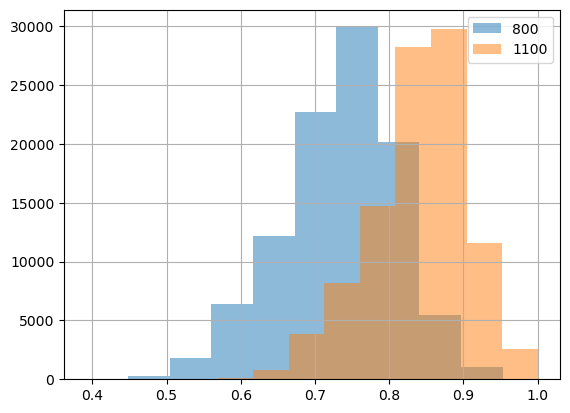

: 

In [ ]:
imodel = 7
istep1 = 800
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_small, imodel, istep1,batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 1100
df_test2, precision2, recall2 = get_df_with_preds(df_small, imodel, istep2 , batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 5000
torch.Size([5000, 88968])
5000 10000
torch.Size([5000, 88968])
10000 15000
torch.Size([5000, 88968])
15000 20000
torch.Size([5000, 88968])
20000 25000
torch.Size([5000, 88968])
25000 30000
torch.Size([5000, 88968])
30000 35000
torch.Size([5000, 88968])
35000 40000
torch.Size([5000, 88968])
40000 45000
torch.Size([5000, 88968])
45000 50000
torch.Size([5000, 88968])
50000 55000
torch.Size([5000, 88968])
55000 60000
torch.Size([5000, 88968])
60000 65000
torch.Size([5000, 88968])
65000 70000
torch.Size([5000, 88968])
70000 75000
torch.Size([5000, 88968])
75000 80000
torch.Size([5000, 88968])
80000 85000
torch.Size([5000, 88968])
85000 90000
torch.Size([5000, 88968])
90000 95000
torch.Size([5000, 88968])
95000 100000
torch.Size([5000, 88968])
100000 105000
torch.Size([5000, 88968])
105000 110000
torch.Size([5000, 88968])
110000 115000
torch.Size([5000, 88968])
115000 120000
torch.Size([5000, 88968])
120000 125000
torch.Size([5000, 88968])
125000 130000
torch.Size([5000, 88968])
13000

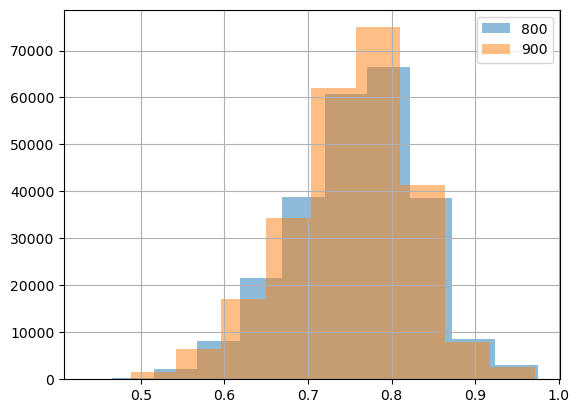

In [65]:
imodel = 7
istep1 = 800
th = 0.9
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1 = df_test1.copy(deep=True)
istep2 = 900
df_test2, precision2, recall2 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep2,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
df_test2['pred_prob'].hist(alpha=0.5)
plt.legend([istep1,istep2])

0 84565
torch.Size([84565, 2001])
200 0.9263465900237201 0.632684916927807
0 84565
torch.Size([84565, 2001])
2000 0.9263465900237201 0.632684916927807
0 84565
torch.Size([84565, 2001])
2200 0.8617562838052816 0.12811446816058653


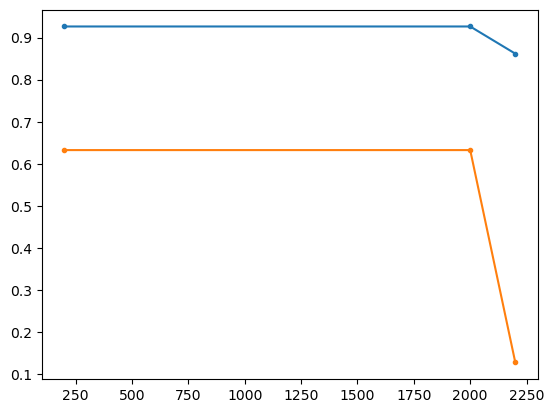

In [59]:
prec_vec, recall_vec = [], []
th = 0.9

istep in range(100, 300, 400):
# istep_range =  [200,2000,2200]
for istep in istep_range:
   
   model_name = f"/home/sagemaker-user/models/model{imodel}-{istep}"
   model = SentenceTransformer(model_name)
   df_test['pred_prob'] = 0.0
   df_test['pred_merchant']=""
   df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)
   precision, recall = get_prec_recall(df_test, th)
   print(istep, precision, recall)
   prec_vec.append(precision)
   recall_vec.append(recall)
plt.plot(istep_range,prec_vec,'.-')
plt.plot(istep_range,recall_vec,'.-')

In [44]:
#df_test1, precision1, recall1 = get_df_with_preds(df_test, imodel, 600, batch_size_pred)
#df_test2 has the lastest epoch

In [45]:
df_test2.head(2)

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9808587425,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,SSA TREAS 310 DES:XXSOC SEC ID: C1 SSA INDN:AN...,Social Security Administration,0,Social Security Administration,1487.0,Social Security Administration,1,0.569095,0.640982,Pps
1,9824575271,Freddys 110- San Antonio Tx. Channel: in store...,Freddys 110- San Antonio Tx. Type: merchant. C...,Freddys 110- San Antonio Tx,Freddys Frozen Custard,0,Freddys Frozen Custard,-24.1,Freddys Frozen Custard,1,0.831068,0.825325,Freddys Mobile


### One epoch score distribution

0 5000
torch.Size([5000, 88968])
5000 10000
torch.Size([5000, 88968])
10000 15000
torch.Size([5000, 88968])
15000 20000
torch.Size([5000, 88968])
20000 25000
torch.Size([5000, 88968])
25000 30000
torch.Size([5000, 88968])
30000 35000
torch.Size([5000, 88968])
35000 40000
torch.Size([5000, 88968])
40000 45000
torch.Size([5000, 88968])
45000 50000
torch.Size([5000, 88968])
50000 55000
torch.Size([5000, 88968])
55000 60000
torch.Size([5000, 88968])
60000 65000
torch.Size([5000, 88968])
65000 70000
torch.Size([5000, 88968])
70000 75000
torch.Size([5000, 88968])
75000 80000
torch.Size([5000, 88968])
80000 85000
torch.Size([5000, 88968])
85000 90000
torch.Size([5000, 88968])
90000 95000
torch.Size([5000, 88968])
95000 100000
torch.Size([5000, 88968])
100000 105000
torch.Size([5000, 88968])
105000 110000
torch.Size([5000, 88968])
110000 115000
torch.Size([5000, 88968])
115000 120000
torch.Size([5000, 88968])
120000 125000
torch.Size([5000, 88968])
125000 130000
torch.Size([5000, 88968])
13000

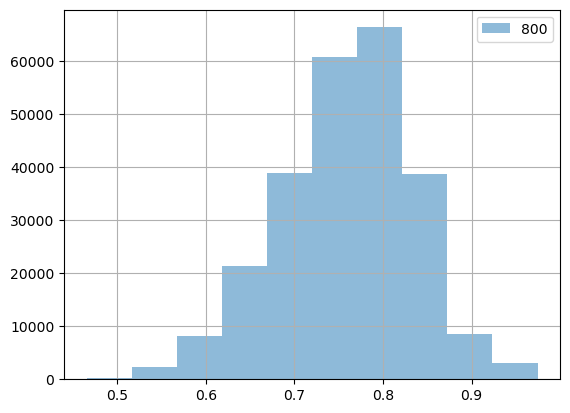

In [47]:
# one epoch

imodel = 7
istep1 = 800
th = 0.8
df_test1, precision1, recall1 = get_df_with_preds(df_test.reset_index(drop=True), imodel, istep1,batch_size_pred)
df_test1['pred_prob'].hist(alpha=0.5)
plt.legend([istep1])

In [ ]:
#   original_merchant_name_combined is the real one ,
# merchant_name_cobined is the modified duplicate with coutnerprty 
# df_trans['original_merchant_name_combined'] = df_trans['merchant_name_combined']
# for duplicates , if counterparty_name != merchatn, then merchant_name_combined = counterparty_name
# merchant_name_combined : for duplicates, take

In [48]:
df_confident_duplicates = df_test1[(df_test1['pred_prob']>0.7) & (df_test['is_duplicate']==1)][['transaction_id','description_combined_processed','pred_merchant','original_merchant_name_combined','pred_prob','is_duplicate','merchant_name_combined']]
df_confident_duplicates

,transaction_id,description_combined_processed,pred_merchant,original_merchant_name_combined,pred_prob,is_duplicate,merchant_name_combined
18,9817361268,PURCHASE AUTHORIZED ON 05/15 H-E-B #372 SAN AN...,H-E-B,Heb,0.734551,1,H-E-B
29,9804645681,"7-ELEVEN , + , TX",7-Eleven,7 Eleven,0.889205,1,Albert
110,9811478214,Credit/Debit Card Deposit: Deposit Debit Card ...,Dave Inc,Dave Inc,0.775294,1,Welcome
134,9829638427,PURCHASE AUTHORIZED ON 05/15 T J MAXX 4TH AV R...,T J Maxx,T.J.Maxx,0.742390,1,POS Deposit
223,9815154752,PURCHASE AUTHORIZED ON 05/15 HARRIS TEETER #0 ...,Harris Teeter,Harris Teeter,0.728557,1,Dave Inc
...,...,...,...,...,...,...,...
248489,9826746296,PURCHASE AUTHORIZED ON 05/14 IN-N-OUT EL CAJON...,In-n-out Redding,In N Out Burger,0.709448,1,In-N-Out Burger
248493,9808076466,RACETRAC454 PORT ALLEN LA PS ...,Racetrac,Racetrac,0.801910,1,RaceTrac
248539,9951538871,Withdrawal POS # H-E-B #798 WOODLAND HILLS DR ...,H-E-B,Heb,0.719373,1,Cash Withdrawal
248557,9797940071,Point Of Sale Withdrawal KWIK STAR #283 CEDAR ...,Kwik Star,Kwik Trip / Star,0.817814,1,Kwik Star


In [49]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

,transaction_id,description_combined_processed,pred_merchant,original_merchant_name_combined,pred_prob,is_duplicate,merchant_name_combined
29,9804645681,"7-ELEVEN , + , TX",7-Eleven,7 Eleven,0.889205,1,Albert
110,9811478214,Credit/Debit Card Deposit: Deposit Debit Card ...,Dave Inc,Dave Inc,0.775294,1,Welcome
134,9829638427,PURCHASE AUTHORIZED ON 05/15 T J MAXX 4TH AV R...,T J Maxx,T.J.Maxx,0.742390,1,POS Deposit
223,9815154752,PURCHASE AUTHORIZED ON 05/15 HARRIS TEETER #0 ...,Harris Teeter,Harris Teeter,0.728557,1,Dave Inc
245,9866372551,SHIPLEY DO-NUTS - FC52 281- TX 05/14,Shipley Do-nuts,Shipley Donuts,0.811022,1,Apple
...,...,...,...,...,...,...,...
248326,9819322123,Point of Sale Debit L340 TIME 05:44 PM DATE 05...,Ulta,Ulta,0.754578,1,Ulta Beauty
248489,9826746296,PURCHASE AUTHORIZED ON 05/14 IN-N-OUT EL CAJON...,In-n-out Redding,In N Out Burger,0.709448,1,In-N-Out Burger
248493,9808076466,RACETRAC454 PORT ALLEN LA PS ...,Racetrac,Racetrac,0.801910,1,RaceTrac
248539,9951538871,Withdrawal POS # H-E-B #798 WOODLAND HILLS DR ...,H-E-B,Heb,0.719373,1,Cash Withdrawal


### Common confusions

In [50]:
df_confident_duplicates['pred_vs_true'] = df_confident_duplicates['pred_merchant']+ ' ::  ' + df_confident_duplicates['original_merchant_name_combined']

In [51]:
df_potential_duplicates = df_confident_duplicates[df_confident_duplicates['pred_merchant'] != df_confident_duplicates['original_merchant_name_combined']]['pred_vs_true'].value_counts().to_frame()
df_potential_duplicates.reset_index(drop=False, inplace=True)
df_potential_duplicates[0:30]

,pred_vs_true,count
0,7-Eleven :: 7 Eleven,547
1,AfterPay :: Afterpay,357
2,FanDuel :: Fan Duel Sportsbook,313
3,Klover App :: Klover,247
4,Dunkin&#39 :: Dunkin'' Donuts,234
5,Ziply Fiber :: Zip In,203
6,DraftKings :: Draftkings,198
7,3 C Market 5640 :: 365 Markets,163
8,Dave Membership :: Dave Inc,155
9,Klover Plus :: Klover,131


In [52]:
df_potential_duplicates[df_potential_duplicates['count']>=3]

,pred_vs_true,count
0,7-Eleven :: 7 Eleven,547
1,AfterPay :: Afterpay,357
2,FanDuel :: Fan Duel Sportsbook,313
3,Klover App :: Klover,247
4,Dunkin&#39 :: Dunkin'' Donuts,234
...,...,...
219,Cvsextracare X6 :: CVS Pharmacy,3
220,Klarna :: SHEIN,3
221,SoFi :: So Fi,3
222,Crunchyroll Com :: Crunchyroll Member,3


In [53]:
# with a threshold of 0.8
# Looking at duplicates and a minimum of 3 transactions , 
true_positives_duplicates = df_potential_duplicates[df_potential_duplicates['count']>=2].shape[0]
true_positives_duplicates

284

In [54]:
#false negatives
false_negatives_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) ].shape[0]

In [59]:
df_test1.head()

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
0,9817740680,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,XX DDA POS PURCH 05/16 06:54 MURPHY ATWALM BLA...,Murphy Express,0,Murphy Express,-50.0,Amazon Prime,0,0.069947,0.732704,Murphy6778 Atwal Baton Rouge
1,9809148759,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL. Chann...,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL. Type:...,SIGNATURE DEBIT CIRCLE K # MACCLENNY FL,Circle K,0,Circle K,-0.7,Online Banking Transfer,0,0.056713,0.816716,Circle K
2,9809106548,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETU...,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETU...,SAMS CLUB # 05-13 CAPE CORALFL DEBIT CARD RETURN,Sam''s Club,0,Sam''s Club,38.3,Sam''s Club,1,0.907195,0.719998,Sam''s Club
3,9836473294,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,POS Withdrawal - AVIAGAMES INC WYANDOTTE ST # ...,Avia Games,0,Avia Games,-5.0,Avia Games,1,0.840230,0.786127,Aviagames Inc
4,9906936396,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,VISA DDA PUR AP GRID PYMNT QPRPKDPP39Y18 GETGR...,Grid,0,Grid,-30.6,7 Eleven,0,0.109405,0.709312,Grid App


In [62]:
 not_confident_duplicates = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.7) & (df_test1['pred_merchant']!= df_test['original_merchant_name_combined'])][['pred_prob','pred_merchant','original_merchant_name_combined']]
 not_confident_duplicates

,pred_prob,pred_merchant,original_merchant_name_combined
324,0.665494,AfterPay,Afterpay
556,0.697389,Savings Gas,Savings
630,0.686148,Savings Gas,Savings
659,0.615056,AfterPay,Afterpay
686,0.651179,Wells Fargo,Wells Fargo Card
...,...,...,...
248528,0.665673,Supplement Giant,Giant Food Inc
248535,0.612956,Savings Gas,Savings
248549,0.653048,Cash's,Cash App
248594,0.591225,Paymt,Pay Activ


In [63]:
not_confident_duplicates['pred_vs_true'] = not_confident_duplicates['pred_merchant']+ ' ::  ' + not_confident_duplicates['original_merchant_name_combined']

In [64]:
not_confident_duplicates['pred_vs_true'].value_counts()

pred_vs_true
Savings Gas ::  Savings                          399
Cash App. ::  Cash App                           131
Wf Credit Card ::  Cash Withdrawal                97
PayPal ::  Paypal                                 40
AfterPay ::  Afterpay                             38
                                                ... 
Jpmc Ncc Cafe ::  Jpmc Cafe Mashgin Plano          1
Citi Card ::  Cash Withdrawal                      1
Capital One Europe ::  Capital One Mobile Pmt      1
Cashnet ::  Cashnetusa                             1
Paymt ::  Pay Activ                                1
Name: count, Length: 648, dtype: int64

In [55]:
false_negatives_duplicates

4085

In [163]:
false_negatives_duplicates_data = df_test1[(df_test1['is_duplicate']==1) & (df_test1['pred_prob']<0.75) ]
false_negatives_duplicates_data

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
71,9825560235,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,ONLINE TRANSFER FROM MCNAIR A WAY2SAVE SAVINGS...,Wells Fargo,1,Savings,150.0,Sheetz,0,0.139824,0.709434,Savings Gas
96,9816972326,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,676.6,Wells Fargo,1,0.901449,0.682301,Savings
164,9843025034,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Withdrawal Debit Card SIGNATURE BASED Prime Vi...,Amazon Prime Video,1,Amazon Prime,-5.0,Amazon Prime Video,1,0.885940,0.687408,Amazon Prime Video
213,9810690095,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,NON-WF ATM WITHDRAWAL AUTHORIZED ON 05/15 710 ...,Wells Fargo,1,Cash Withdrawal,-23.4,Wells Fargo,1,0.994184,0.633307,Wf Credit Card
259,9819471143,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM HICKS S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,10.0,In N Out Burger,0,0.090042,0.678695,Savings
...,...,...,...,...,...,...,...,...,...,...,...,...,...
249087,9823298075,NON-CHASE ATM WITHDRAW 05/ BROAD. Channel: Non...,NON-CHASE ATM WITHDRAW 05/ BROAD. Type: financ...,NON-CHASE ATM WITHDRAW 05/ BROAD,Chase Bank,1,Cash Withdrawal,-22.0,Chase Bank,1,0.766347,0.749209,Chase Bank
249171,9842720171,POS Debit - Visa Check Card - KLOVER APP BOOST...,POS Debit - Visa Check Card - KLOVER APP BOOST...,POS Debit - Visa Check Card - KLOVER APP BOOST...,Klover App,1,Klover,-82.4,Steam,0,0.282852,0.746376,Klover App
249193,9842856838,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,POS Adjustment - APPLE CASH INST XF CUPERTINO ...,Apple Cash,1,Adjustment,98.5,Snapmath,0,0.035135,0.663559,Apple Cash
249324,9819222557,CVS/PHARM - -- South B Alv - . Channel: in sto...,CVS/PHARM - -- South B Alv - . Type: merchant....,CVS/PHARM - -- South B Alv -,CVS,1,CVS Pharmacy,-30.1,CVS,1,0.829987,0.716642,CVS Pharmacy


'Cash App'

In [129]:
df_potential_duplicates[-30:]

,pred_vs_true,count
797,Cash App Aaliyah :: Cash App Transfer,1
798,Cash App Dee :: Cash App Dee Hicks,1
799,Cash App Mel :: Cash App Mellow,1
800,Cash App K D :: Cash App Kobie,1
801,Cash App Cjay :: Cash App Pjay,1
802,Cash App Madison :: Cash App Transfer,1
803,Cash App Travis Tho :: Cash App Arturo,1
804,Cash App Kenna :: Cash App Kennia,1
805,Cash App Fab :: Cash App Fam,1
806,Cash App Anthony S :: Cash App Anthony R,1


In [ ]:
df_potential_duplicates

In [114]:
df_confident_duplicates['pred_vs_true'].value_counts()

pred_vs_true
Dave Inc Dave Inc                          821
7-Eleven 7 Eleven                          470
Afterpay Afterpay                          198
Dunkin'' Dunkin'' Donuts                   190
CVS Pharmacy CVS Pharmacy                  174
                                          ... 
Cash App Ke Cash App Keosha                  1
Cash App Des Cash App Desean                 1
Oportun Rainy Day Oportun Rainy Day          1
Cash App Ashley Burton                       1
Cash App Carla Point Of Sale Withdrawal      1
Name: count, Length: 1415, dtype: Int64

In [ ]:
df_confident_duplicates[df_confident_duplicates['pred_merchant'] !=  df_confident_duplicates['merchant_name_combined']]

In [52]:
get_prec_recall(df_test1, th=0.8)

(0.6416177147343061, 0.202415112386418)

### How many of the duplicates did it find?

In [59]:
all_duplicates = df_test2[df_test2['is_duplicate'] == 1][:]
all_duplicates[all_duplicates['pred_merchant']!= all_duplicates['true_merchant_name_combined']]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,is_duplicate,original_merchant_name_combined,amount,merchant_name_combined,true_label,label,pred_prob,pred_merchant
8,9809396647,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRI...,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRI...,PURCHASE ZIP* QUADPAY ANYWHE XXX-XX NY RECURRING,Zip.co,1,Zip In,-14.2,Zip.co,1,0.680956,0.737677,Ziply Fiber
45,9816972326,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,ONLINE TRANSFER FROM YOUNG S WAY2SAVE SAVINGS ...,Wells Fargo,1,Savings,676.6,Wells Fargo,1,0.901449,0.667018,Savings
47,9808523732,PROGRESSIVELEASE PMTS . Channel: None. Amount:...,PROGRESSIVELEASE PMTS . Type: financial_instit...,PROGRESSIVELEASE PMTS,Progressive Leasing,1,Progressive Lease,-48.3,Progressive Leasing,1,0.793004,0.761640,Progressive Lease
59,9811980660,PURCHASE FORTIVA MC. Channel: None. Amount: -25.0,PURCHASE FORTIVA MC. Type: financial_instituti...,PURCHASE FORTIVA MC,Fortiva,1,Fortiva Mc,-25.0,Fortiva,1,0.895653,0.880212,Fortiva Mc
62,9812485334,CHECKCARD CHIPOTLE GRAND PRAIRIETX . Channel: ...,CHECKCARD CHIPOTLE GRAND PRAIRIETX . Type: mer...,CHECKCARD CHIPOTLE GRAND PRAIRIETX,Chipotle Mexican Grill,1,Chipotle,-55.4,Chipotle Mexican Grill,1,0.876486,0.829878,Chipotle
...,...,...,...,...,...,...,...,...,...,...,...,...,...
116920,9808807006,"DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...","DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...","DB DEBIT - 5-15- , FANDUELSBKPRIMARY NJ,AUTH# ...",FanDuel Sportsbook,1,Fan Duel Sportsbook,-5.0,FanDuel Sportsbook,1,0.932282,0.770255,FanDuel
116945,9869711828,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,ONLINE TRANSFER TO MICHEL R WAY2SAVE SAVINGS R...,Wells Fargo,1,Savings,-80.0,Wells Fargo,1,0.897926,0.622277,Savings To Checking
117027,9841744734,CASH APP*CARLA*ADD San Francisco CAUS. Channe...,CASH APP*CARLA*ADD San Francisco CAUS. Type: ...,CASH APP*CARLA*ADD San Francisco CAUS,Cash App,1,Point Of Sale Withdrawal,-25.0,Cash App,1,0.863087,0.805727,Cash App Carla
117066,9819222557,CVS/PHARM - -- South B Alv - . Channel: in sto...,CVS/PHARM - -- South B Alv - . Type: merchant....,CVS/PHARM - -- South B Alv -,CVS,1,CVS Pharmacy,-30.1,CVS,1,0.829987,0.717721,4cvs Pharm


In [55]:
#Let's look at the duplicates quality with the first epoch
some_cols = ['transaction_id','pred_prob','pred_merchant','true_merchant_name_combined','original_merchant_name_combined','description_combined_processed','is_duplicate']
df_potential_dups = df_test2[(df_test2['pred_prob']>0.8) & (df_test2['true_merchant_name_combined'] != df_test2['pred_merchant'])][some_cols]
df_potential_dups.reset_index(drop=True, inplace=True)
df_potential_dups

,transaction_id,pred_prob,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,description_combined_processed,is_duplicate
0,9824575271,0.825325,Freddys Mobile,Freddys Frozen Custard,Freddys Frozen Custard,Freddys 110- San Antonio Tx,0
1,9831911149,0.843733,Tp 7 Brew Sb,Brew Sb,Brew Sb,Withdrawal TIL*TP 7 BREW SB267 ( -05-17),0
2,9819513927,0.862629,7-Eleven,7 Eleven,7 Eleven,7-ELEVEN 05/15 # PURCHASE 7-ELEVEN Redondo Bea...,0
3,9818899162,0.838592,Uber Eat,Uber Eats,Uber Eats,UBER EATS CA Mobile Purchase Sign Based 05/13 ...,0
4,9809746890,0.836114,FanDuel,Fan Duel Sportsbook,Fan Duel Sportsbook,PURCHASE AUTHORIZED ON 05/14 FANDUELSBKPRIMARY...,0
...,...,...,...,...,...,...,...
13234,9800634706,0.849260,Dunkin'',Dunkin'' Donuts,Dunkin'' Donuts,DUNKIN # Q35,0
13235,9816584906,0.815012,Target St,Target,Target,Pos Debit- Target Winter Garden FL,0
13236,9801827245,0.803302,Zip Gift Cards,Zip In,Zip In,ZIP PAYMENT D218EA,0
13237,9827676688,0.875824,Affirmcard,Affirm,Affirm,AFFIRM INC AFFIRM PAY WEB ID:,0


In [56]:
df_test1[ (df_test1['is_duplicate']==1) & (df_test1['pred_prob']>0.8)][some_cols]

,transaction_id,pred_prob,pred_merchant,true_merchant_name_combined,original_merchant_name_combined,description_combined_processed,is_duplicate
651,9819624864,0.853664,Greenline Loans I Db,Greenline Loans I Db,Greenline Loans,Greenline Loans/I DB,1
1269,10022989596,0.840014,Mbi Huck''s Food & Fuel,Huck''s Food & Fuel Store,Huck''s Food & Fuel,HUCK''S FOOD & FUEL STO Sturgis K,1
1793,9808270487,0.822527,Esg Mobig.Co/Helppayca,Scopely,Scopely Inc,GOOGLE *Scopely Inc g.co/helppay#CA,1
4849,9805530838,0.891283,Five Star Food Service,Five Star Food Service,Five Star Food,Five Star Food Services,1
4913,9889556734,0.883503,Fresh Donuts,AVON,Avon,Avon Fresh Donuts,1
...,...,...,...,...,...,...,...
276821,9800122549,0.835972,Parkwhiz Inc,ParkWhiz,Parkwhiz Inc,"ParkWhiz, Inc.",1
277096,9837916194,0.876182,AviaGames,AviaGames,Avia Games,Aviagames,1
277698,9838521876,0.925392,Total Wine And More,Total Wine & More,Total Wine And More,Total Wine And More,1
277872,9830287878,0.863770,Credit One Bank,Credit One Bank,Credit One Bank Payment,Credit one bank,1


In [57]:
df_test1['merchant_pairs'] = df_test1.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [58]:
#df_potential_dups['merchant_pairs'] = df_potential_dups['true_merchant_name_combined']
df_potential_dups['merchant_pairs'] = df_potential_dups.apply(lambda x: x['true_merchant_name_combined']+ ' , ' + x['pred_merchant'], axis=1)

In [59]:
df_duplicate_cand_counts = df_potential_dups[['merchant_pairs']].value_counts().to_frame()
df_duplicate_cand_counts.reset_index(drop=False, inplace=True)
df_duplicate_cand_counts[0:30]

,merchant_pairs,count
0,"60 , Direct Debit Payment",98
1,"Walmart , Wal-martsuper Center",70
2,"7 Eleven , 7-Eleven",58
3,"Loan Payment , Onl To Loan",53
4,"Netflix , Netflix.co",48
5,"Racetrac , RaceTrac",41
6,"Hy-Vee , Hy Vee F&f",39
7,"Dominos Pizza , Domino''s",36
8,"Brigit , Brigit-com Protection",33
9,"Paypal , Paypal Pay in 4",27


In [133]:
df_data_processed[df_data_processed['transaction_id']==9790597722]

,transaction_id,corrected_made_on,amount,description_combined,merchant_name_combined,description_combined_processed,sentence,sentence2,payment_channel
1647418,9790597722,2024-05-14,-20.0,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,in store
3428017,9790597722,2024-05-14,-20.0,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,in store


In [131]:
df_data_raw[df_data_raw['transaction_id']==9790597722]

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
150,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Select Media,0,0.014969
1628330,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Cleo Re,1,0.948677


In [127]:
df_train[df_train['true_merchant_name_combined']=='Cleo Re']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
1262,9790597722,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Withdrawal PFCU Check Card / Cleo Repayments W...,Cleo Re,Cleo Re,1,0.948677
3619,9795191791,Withdrawal / Cleo Repayments Wilmington DE Dat...,Withdrawal / Cleo Repayments Wilmington DE Dat...,Withdrawal / Cleo Repayments Wilmington DE Dat...,Cleo Re,Perkins Restaurant,0,0.277537
4330,9808878466,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Debit Card Purchase 05/10 06:23p # Cleo Repaym...,Cleo Re,American,0,0.111405
4446,9797957291,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,XX POS PURCHASE 05/13 11:46 Cleo Repayments Wi...,Cleo Re,Zelle,0,0.378786
5379,9802546059,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Debit Card Purchase 05/11 10:28a # Cleo Repaym...,Cleo Re,McDonald''s,0,0.292131
...,...,...,...,...,...,...,...,...
1436153,9790173252,Withdrawal Visa Check Card&#10;Cleo Repayments...,Withdrawal Visa Check Card&#10;Cleo Repayments...,Withdrawal Visa Check Card&#10;Cleo Repayments...,Cleo Re,Albert,0,0.168328
1436308,9792257934,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Point Of Sale Withdrawal Cleo Repayments Wilmi...,Cleo Re,Cleo Re,1,0.800572
1437887,9808944187,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,Cleo Re,Chipotle Mexican Grill,0,0.084006
1442397,9790908150,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,DC Cleo Repayments Wilmington DE Ref: Auth: Pu...,Cleo Re,Amazon,0,0.054192


In [130]:
df_test1[df_test1['merchant_pairs'] =='Cleo , Cleo Re']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob,merchant_pairs
208,9807912941,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,CHECKCARD CLEO AI XXXXX DE XXXXX XXXXXXXXXX RE...,Cleo,Cleo,1,0.852102,Cleo Re,0.947559,"Cleo , Cleo Re"
527,9797927822,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C# . Ch...,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C# . Ty...,DBT CRD DJM1FX4D CLEO AI WILMINGTON DE C#,Cleo,McDonald''s,0,0.366720,Cleo Re,0.939316,"Cleo , Cleo Re"
627,9792924553,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Check Card Purchase / CLEO AI HTTPSWWW.MEET DE...,Cleo,Cleo,1,0.627847,Cleo Re,0.949093,"Cleo , Cleo Re"
918,9800957847,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo,Curt''s Ace Hardwar,0,0.072751,Cleo Re,0.947932,"Cleo , Cleo Re"
973,9800813077,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre. Chann...,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre. Type:...,Cleo AI Cleo AI IW8GXJVX4 Molly Aguirre,Cleo,Target,0,0.273019,Cleo Re,0.954352,"Cleo , Cleo Re"
...,...,...,...,...,...,...,...,...,...,...,...
83730,9800072565,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo Salary Ad 05/14 #XXXXX PMNT RCVD Cleo Sal...,Cleo,7-Eleven,0,0.134340,Cleo Re,0.947932,"Cleo , Cleo Re"
83876,9798919680,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,RECURRING PAYMENT AUTHORIZED ON 05/13 CLEO AI ...,Cleo,FanDuel Sportsbook,0,0.015474,Cleo Re,0.950078,"Cleo , Cleo Re"
84283,9798098202,Cleo AI Cleo AI ***********4RVG. Channel: None...,Cleo AI Cleo AI ***********4RVG. Type: financi...,Cleo AI Cleo AI ***********4RVG,Cleo,Zelle,0,0.071392,Cleo Re,0.943132,"Cleo , Cleo Re"
84438,9806902078,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME...,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME...,RECURRING DEBIT CARD XXXXX CLEO AI HTTPSWWW.ME DE,Cleo,Cash App,0,0.175634,Cleo Re,0.948485,"Cleo , Cleo Re"


In [120]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']['description_combined_processed'].tolist()

['GIANT PADOVER P',
 'CHECKCARD GIANT FOOD INC GERMANTOWN MD',
 'GIANT ALLENT CAMP SPRINGS MD',
 'GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD PURCHASE-PIN',
 'GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Withdrawal Debit Card DEBIT-PURCHASE',
 'GIANT ALEXANDRIA VA Card /Withdrawal POS # ',
 'GIANT , OXON HILL, MD',
 'GIANT BELAIR MD',
 'GIANT BETHLEHEM PA',
 'GIANT LANDOVER 05/14 #XXXXX MOBILE PURCHASE GIANT LANDOVER #2 FAIRFAX VA',
 'MOBILE PURCHASE GIANT FOOD INC #166 BALTIMORE MD XXXXX XXXXXXXXXX ',
 'GIANT FOOD INC 05/14 #XXXXX PURCHASE GIANT FOOD INC #1 BALTIMORE MD',
 'PURCHASE AUTHORIZED ON 05/14 GIANT FOOD INC #150 GAITHERSBURG MD P CARD ',
 'GIANT 462 05/14 #XXXXX MOBILE PURCHASE GIANT E BALTIMORE MD',
 'GIANT BENSALEM PADate 05/14/24 Card RRN /Withdrawal Debit Card DEBIT-PURCHASE',
 'GIANT ',
 'GIANT 105 05/14 #XXXXX PURCHASE GIANT LARGO MD',
 'GIANT 810 05/14 #XXXXX PURCHASE GIANT L TOWSON MD',
 'GIANT 329 05/14 #XXXXX MOBILE PURCHASE GIANT C WALDORF MD',
 'GIANT FOOD # DOYL

In [121]:
df_train[df_train['true_merchant_name_combined']=='Giant']['description_combined_processed'].tolist()

['PURCHASE AUTHORIZED ON 05/14 GIANT CHAMBERSBURG PA P CARD ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT ALEXANDRIA VA P CARD ',
 'PURCHASE WITH CASH BACK $ 20.00 AUTHORIZED ON 05/14 GIANT BRANCH MARLOW HEIGHT MD P CARD ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT HARRISBURG PA P CARD ',
 'PURCHASE AUTHORIZED ON 05/13 GIANT LANCASTER PA S CARD ',
 'Debit Card purchase GIANT GREENBELT MD',
 'CHECKCARD GIANT HARLEYSVILLE PA XXXXX XXXXXXXXXX ',
 'PURCHASE AUTHORIZED ON 05/13 DD DOORDASH GIANT 855-973- CA S CARD ',
 'DBT CRD 05/14/24 GIANT QUAKERTOWN PA C# ',
 'PURCHASE AUTHORIZED ON 05/14 GIANT # SEVEN FALLS CHURCH VA P CARD ',
 'MOBILE PURCHASE GIANT WASHINGTON DC XXXXX XXXXXXXXXX ',
 'DDA PURCHASE AP GIANT 177 PEMBROKE PARK * FL',
 'PURCHASE AUTHORIZED ON 05/14 GIANT BURKE VA P CARD ',
 'Purchase GIANT -50 YOR BALTIMORE US',
 'PIN GIANT CARLISLE',
 'MD LOT GIANT # ',
 'POS PUR GIANT / GIANT CAMP HILL PA REG 1 POS DEBIT',
 'MOBILE PURCHASE GIANT LEESBURG VA XXXXX XXXXXXXXXX ',
 'VISA DDA PUR AP GI

In [123]:
df_train[df_train['true_merchant_name_combined']=='Giant Food']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label
2463,9788502083,GIANT PADOVER P. Channel: in store. Amount: -39.7,GIANT PADOVER P. Type: merchant. Channel: in s...,GIANT PADOVER P,Giant Food,Giant Food,1,0.813547
13669,9807420435,CHECKCARD GIANT FOOD INC GERMANTOWN MD. Channe...,CHECKCARD GIANT FOOD INC GERMANTOWN MD. Type: ...,CHECKCARD GIANT FOOD INC GERMANTOWN MD,Giant Food,Nbaleaguepas,0,0.021973
16848,9798273140,GIANT ALLENT CAMP SPRINGS MD. Channel: in stor...,GIANT ALLENT CAMP SPRINGS MD. Type: merchant. ...,GIANT ALLENT CAMP SPRINGS MD,Giant Food,Giant Food,1,0.746913
20638,9798950412,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,GIANT JEFFER 05-13-24FREDERICKSBUR DEBIT CARD ...,Giant Food,Giant Food,1,0.979982
22423,9796570694,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,GIANT ST. DAVIDS PADate 05/14/24 Card RRN /Wit...,Giant Food,Credit One Bank,0,0.338793
...,...,...,...,...,...,...,...,...
1435787,9808139466,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,DEBIT CARD PURCHASE XXXXX GIANT FOOD # PHILADE...,Giant Food,Speedway,0,0.378445
1436710,9915626484,GIANT . Channel: in store. Amount: -33.85,GIANT . Type: merchant. Channel: in store. Amo...,GIANT,Giant Food,Giant Food,1,0.824942
1439833,9791404363,GIANT FOOD INC #145 51. Channel: in store. Amo...,GIANT FOOD INC #145 51. Type: merchant. Channe...,GIANT FOOD INC #145 51,Giant Food,Cleo,0,0.055575
1440130,9799068738,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,CHK CRD PALOTV GIA / PALOTV GIANT FOOD S LEBAN...,Giant Food,Ga Driver Svcs On,0,0.074387


In [ ]:
# Example ('Giant', 'Giant Food', 'Giant Food Inc')
# On merchants table Giant Food Inc and Giant exist, they have the same twitter handle, should be deduplicated
# the 
# on transactions table
# 9798583952, Giant, merchant_id = 576243, entertainment, food aand drink, groceries
# 9788502083, merchant_name = None,  Counterparties: Giant Food, giantfood.com, transfer out, food aand drink, groceries

In [117]:
df_test1[df_test1['merchant_pairs'] =='Giant , Giant Food']

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob,merchant_pairs


In [ ]:
# get pairs that have the same m1, m2

In [64]:
model = SentenceTransformer(model_name)
df_test['pred_prob'] = 0.0
df_test['pred_merchant']=""
df_test = do_predictions(model, df_test,text_column, batch_size_pred,embeddings_merchants)

0 84565
torch.Size([84565, 2001])


In [67]:
df_test

,transaction_id,sentence,sentence2,description_combined_processed,true_merchant_name_combined,merchant_name_combined,true_label,label,pred_merchant,pred_prob
0,9798082487,ALLY ALLY PAYMT keanna clark. Channel: None. A...,ALLY ALLY PAYMT keanna clark. Type: financial_...,ALLY ALLY PAYMT keanna clark,Ally Bank,Ally Bank,1,0.985237,Ally Bank,0.549449
1,9804841072,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,PURCHASE LYFT *1 RIDE 05 SAN FRANCISCOCA XXXXX...,Lyft,MoneyLion,0,0.260391,Lyft,0.479348
2,9799411489,"PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...","PURCHASE ACI*CREDIT ONE BANK, N. 877-825- NV X...",Credit One Bank,23 Liquor,0,0.253272,First Bankcard,0.435096
3,9800247899,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,PURCHASE AUTHORIZED ON 05/12 SOLITAIRE CASH NY...,Solitaire Cash,Buffalo Wild Wings,0,0.252959,Solitaire Cash,0.508537
4,9798407232,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,MONEY TRANSFER AUTHORIZED ON 05/12 APPLE CASH ...,Apple Cash,Uber,0,0.075716,Apple Store,0.403420
...,...,...,...,...,...,...,...,...,...,...
84560,9798569849,Pos Debit- Empower Advance Empower.me CA. Chan...,Pos Debit- Empower Advance Empower.me CA. Type...,Pos Debit- Empower Advance Empower.me CA,Empower,Inc Katelynn Fletcher,0,0.143810,Empower,0.421127
84561,9797827093,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. C...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS. T...,Purchase DOLLAR GENERAL # MOUNT PLEASANMIUS,Dollar General,Meta Pay,0,0.044711,Dollar,0.507223
84562,9800675621,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC BANK 05/14 #XXXXX WITHDRWL CENTREVILLE MAN...,PNC,PNC,1,0.841737,First Bankcard,0.369693
84563,9818778881,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA....,N PAYMENT POSMBGB1LNV EMPOWER SAN FRANCISC CA,Empower,Maverik,0,0.123350,World Acceptance,0.288132


In [66]:
precision, recall = get_prec_recall(df_test, th)
print(precision, recall)

ZeroDivisionError: division by zero

In [56]:
recall_vec

[0.632684916927807]

In [47]:
batch_size = 5000
for istart in np.arange(0, df_test.shape[0]+1, batch_size):
    iend = min(df_test.shape[0],istart + batch_size)
    if iend> istart:
        print(istart, iend)
        tx_embeddings = model.encode(df_test['sentence'][istart:iend].tolist())
        similarities = model.similarity(tx_embeddings, embeddings_merchants)
        #print(similarities.shape)
        max_vals = torch.max(similarities, axis=1)
        max_probs = max_vals[0]
        ix_max_merchants = max_vals[1]
        predicted_merchant = [list_unique_merchants[i] for i in ix_max_merchants]
        df_test.loc[istart:iend-1,'pred_merchant'] =  predicted_merchant
        df_test.loc[istart:iend-1,'pred_prob'] =  np.array(max_probs)

0 5000
torch.Size([5000, 2001])
5000 10000
torch.Size([5000, 2001])
10000 15000
torch.Size([5000, 2001])
15000 20000
torch.Size([5000, 2001])
20000 25000
torch.Size([5000, 2001])
25000 30000
torch.Size([5000, 2001])
30000 35000
torch.Size([5000, 2001])
35000 40000
torch.Size([5000, 2001])
40000 45000
torch.Size([5000, 2001])
45000 50000
torch.Size([5000, 2001])
50000 55000
torch.Size([5000, 2001])
55000 60000
torch.Size([5000, 2001])
60000 65000
torch.Size([5000, 2001])
65000 70000
torch.Size([5000, 2001])
70000 75000
torch.Size([5000, 2001])
75000 80000
torch.Size([5000, 2001])
80000 84565
torch.Size([4565, 2001])
